In [465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [466]:
df = pd.read_excel("Superstore.xlsx", index_col="Row ID")

In [467]:
df.shape

(9994, 20)

In [468]:
df.isna().sum()

Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [469]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 1 to 9994
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     9994 non-null   datetime64[ns]
 2   Ship Date      9994 non-null   datetime64[ns]
 3   Ship Mode      9994 non-null   object        
 4   Customer ID    9994 non-null   object        
 5   Customer Name  9994 non-null   object        
 6   Segment        9994 non-null   object        
 7   Country        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Postal Code    9994 non-null   int64         
 11  Region         9994 non-null   object        
 12  Product ID     9994 non-null   object        
 13  Category       9994 non-null   object        
 14  Sub-Category   9994 non-null   object        
 15  Product Name   9994 non-nu

In [470]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [471]:
Sales_by_day_df = df.groupby('Order Date')['Sales'].sum().reset_index()

In [472]:
Sales_by_day_df.drop(columns=['Order Date'], inplace=True)

In [473]:
Sales_by_day_df.head(10)

,Sales
0,16.448
1,288.060
2,19.536
3,4407.100
4,87.158
5,40.544
6,54.830
7,9.940
8,3553.795
9,61.960


In [474]:
Sales_by_day_df.tail(10)

,Sales
1228,2140.9400
1229,7442.0210
1230,1926.7760
1231,6233.0540
1232,2698.9270
1233,814.5940
1234,177.6360
1235,1657.3508
1236,2915.5340
1237,713.7900


In [475]:
split_type = [[0.8,0.2], [0.9, 0.1], [0,75,0.25]]

In [476]:
split = 0

In [477]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(Sales_by_day_df).reshape(-1, 1))

In [478]:
train_size = int(split_type[split][0] * len(df_scaled))
test_size = int(split_type[split][1] * len(df_scaled))

In [479]:
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size : train_size + test_size]

In [480]:
# Function to create dataset input and output, it will convert an array of values into a dataset matrix, use the sliding window with the time_step argument
def create_dataset(data, window_slide):
    X, y = [], []

    for i in range(len(data) - window_slide - 1):
        X.append(data[i : (i + window_slide), 0])
        y.append(data[i + window_slide, 0])

    return np.array(X), np.array(y)

In [481]:
# Define time step, it mean the model will take 10 days before to predict the closing price 'at that time'
WINDOW_SLIDE = 7

# Create X, y for train, test and validate
X_train, y_train = create_dataset(train_data, WINDOW_SLIDE)
X_test, y_test = create_dataset(test_data, WINDOW_SLIDE)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((982, 7), (982,), (239, 7), (239,))

In [482]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [483]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

# Initialize LSTM model
model = Sequential(
    [
        Input((X_train.shape[1], 1)),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1),
    ]
)
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 7, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [484]:
model.compile(optimizer="adam", loss="mse", metrics=["mean_absolute_error"])

In [485]:
EPOCHS = 300
BATCH_SIZE = 32


# Train the model
model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
)

Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0093 - mean_absolute_error: 0.0593 - val_loss: 0.0083 - val_mean_absolute_error: 0.0618
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - mean_absolute_error: 0.0506 - val_loss: 0.0077 - val_mean_absolute_error: 0.0648
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mean_absolute_error: 0.0551 - val_loss: 0.0078 - val_mean_absolute_error: 0.0641
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0540 - val_loss: 0.0081 - val_mean_absolute_error: 0.0622
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - mean_absolute_error: 0.0550 - val_loss: 0.0086 - val_mean_absolute_error: 0.0620
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0520 - val_loss: 0.0087 - val_mean_absolute_error: 0.0620
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0528 - val_los

In [486]:
# Predict and convert the data back - because i reshaped between 0 and 1, so need to convert back
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [487]:
train_data1 = Sales_by_day_df[:train_size]
test_data1 = Sales_by_day_df[train_size : train_size + test_size]

y_test1 = np.array(test_data1)

In [488]:
def forecast(data, window_slide, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-window_slide:]
    y_forecast = []

    for i in range(forecast_days + 1):
        # Reshape x_forecast to have the shape (1, window_side, num_features)
        x_forecast_reshaped = x_forecast.reshape(1, window_slide, x_forecast.shape[1])
        # Predict the next day
        y = model.predict(x_forecast_reshaped)
        y_forecast.append(y[0][0])

        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]

    return y_forecast

In [489]:
y_pred_30_days = forecast(test_data, WINDOW_SLIDE, 30)
# Assuming y_pred_30_days is a 1D array
y_pred_30_days = np.array(y_pred_30_days).reshape(-1, 1)

# Inverse transform y_pred_30_days
y_pred_30_days = scaler.inverse_transform(y_pred_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [490]:
def draw_plot(y_days_predict, days):
    plt.figure(figsize=(10, 6))
    plt.ylabel("Sales")

    # Raw data
    plt.plot(train_data1.index, train_data1, label="Train")
    plt.plot(test_data1.index, test_data1, label="Test")

    # Predict test and validate
    plt.plot(
        test_data1.index[
            WINDOW_SLIDE : len(y_pred) + WINDOW_SLIDE
        ],  # because using the sliding window (WINDOW_SIDE) -> the index of 2 dataset is difference
        y_pred,
        label="Predicted Test",
        linestyle="--",
    )

    # Predict the next 30/60/90 days
    plt.plot(
        test_data1.index[-1] + np.arange(1, len(y_days_predict) + 1),
        y_days_predict,
        label=f"Forecast Next {days} Days",
        linestyle="--",
    )

    plt.legend()
    plt.show()

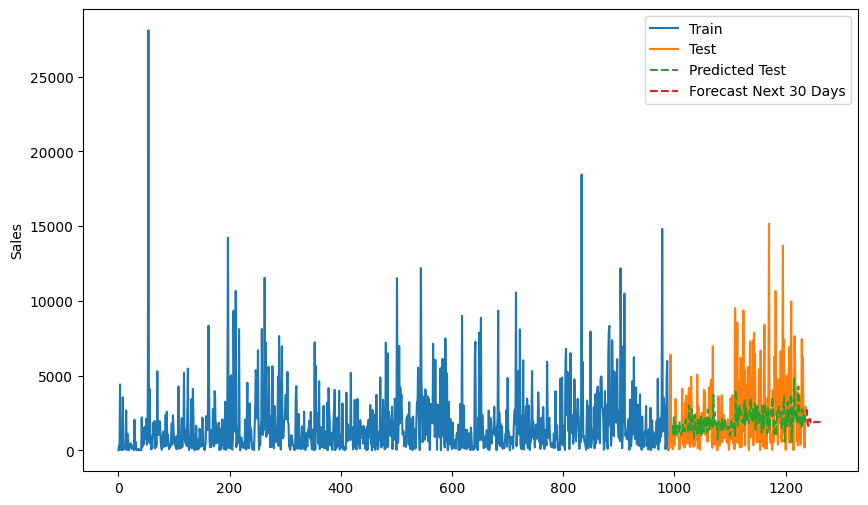

In [491]:
draw_plot(y_pred_30_days, 30)

In [492]:
# Evaluation
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
    mean_absolute_error as mae,
)
def evalute_model(y, y_pred):
    # Because i use the sliding window with the time_step value, so the length of 'y' and 'y predict' will difference
    min_len = min(len(y), len(y_pred))
    y = y[-min_len:]
    y_pred = y_pred[-min_len:]
    
    LSTM_MSE = mse(y, y_pred)
    LSTM_MAE = mae(y, y_pred)
    LSTM_MAPE = mape(y, y_pred) * 100

    error_metrics = {
    'Metric': ['MSE', 'MAE', 'MAPE'],
    'Value': [LSTM_MSE, LSTM_MAE, LSTM_MAPE]
    }
    df_errors = pd.DataFrame(error_metrics)
    return df_errors

In [493]:
evaluate_result = evalute_model(y_test1, y_pred)
evaluate_result.head()

,Metric,Value
0,MSE,6.494208e+06
1,MAE,1.809693e+03
2,MAPE,6.639137e+02
